## NYPD Shooting Incident Data

Link: https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Year-To-Date-/5ucz-vwe8/about_data

List of every shooting incident that occurred in NYC (Last Updated
January 18, 2024).

This is a breakdown of every shooting incident that occurred in NYC during the current calendar year(2023). This data is manually extracted every quarter and reviewed by the Office of Management Analysis and Planning before being posted on the NYPD website.
Each record represents a shooting incident in NYC and includes information about the event, the location and time of occurrence. In addition, information related to suspect and victim demographics is also included.

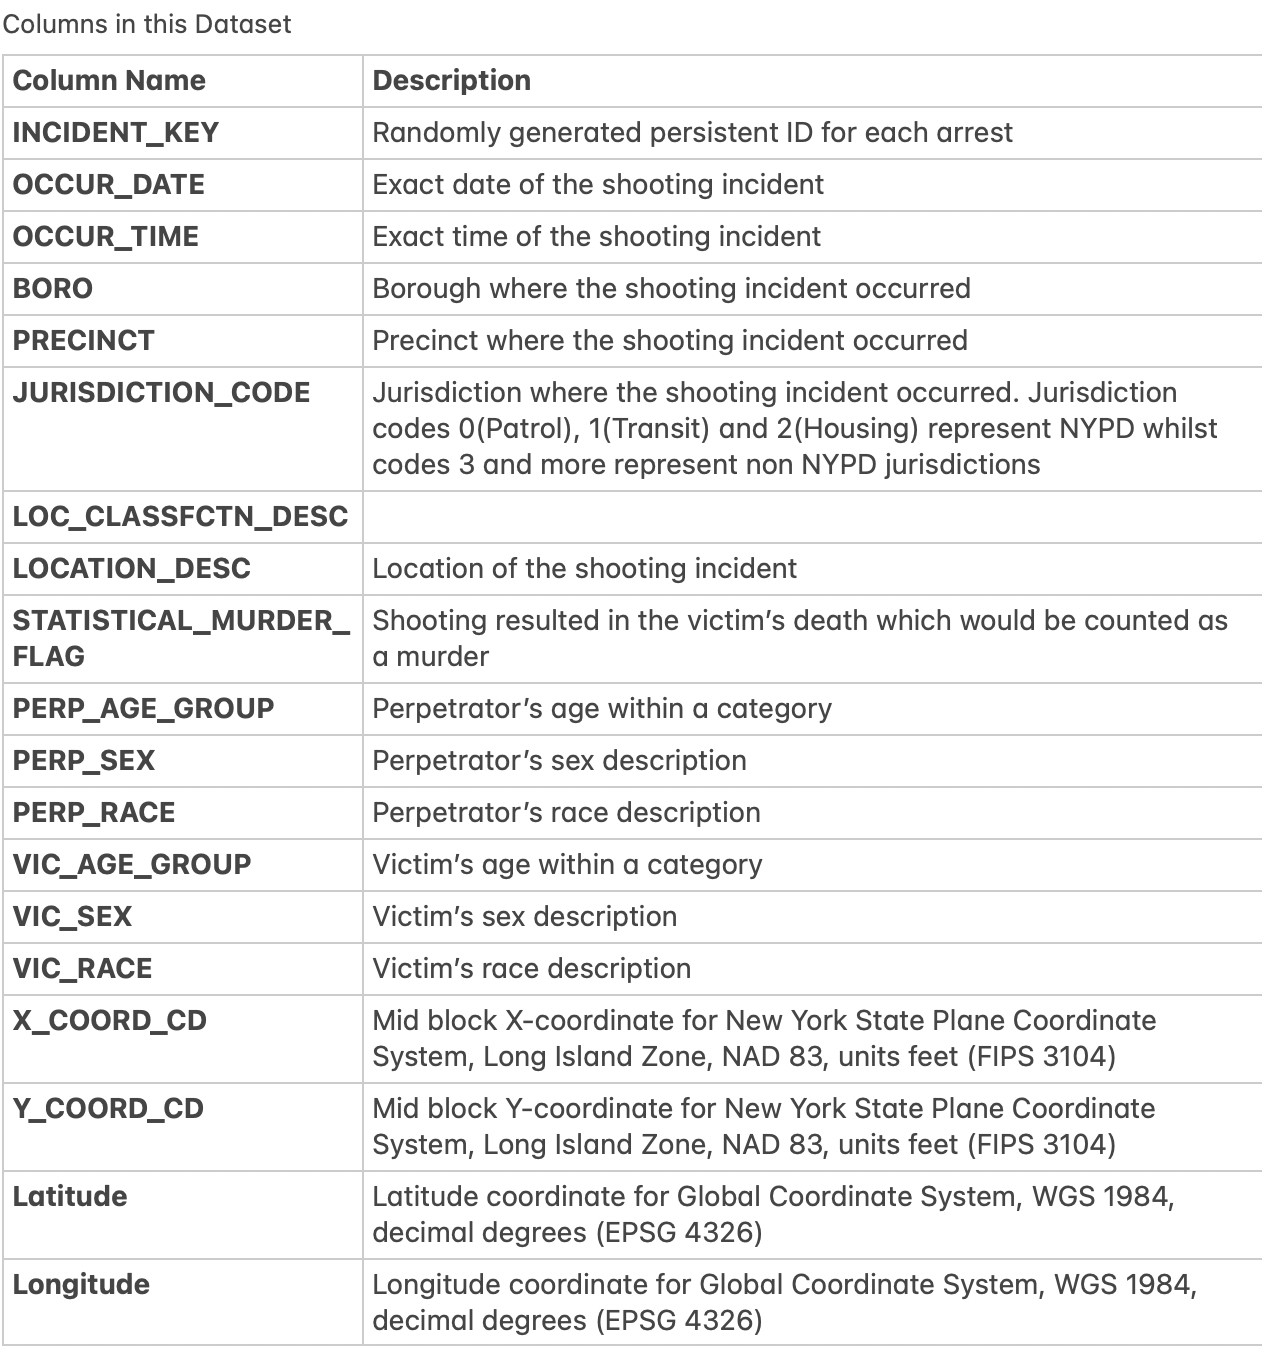

## Exploratory Data Analysis

# **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Processing**

In [5]:
df=pd.read_csv('/content/drive/MyDrive/Data/ML Final Project/NYPD_Shooting_Incident_Data__Year_To_Date__20240421.csv')
df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,269311789,06/04/2023,21:01:00,QUEENS,OUTSIDE,109,0,STREET,(null),N,...,M,WHITE HISPANIC,25-44,M,WHITE HISPANIC,1032051,217053,NaN,NaN,NaN
1,270085087,06/19/2023,22:05:00,MANHATTAN,OUTSIDE,33,0,OTHER,(null),N,...,(null),(null),25-44,F,BLACK,1001891,245600,NaN,NaN,NaN
2,272881671,08/14/2023,02:50:00,BROOKLYN,OUTSIDE,69,0,COMMERCIAL,GAS STATION,N,...,(null),(null),25-44,M,BLACK,1010541,175595,NaN,NaN,NaN
3,270388044,06/25/2023,21:05:00,QUEENS,OUTSIDE,100,1,TRANSIT,(null),N,...,(null),(null),25-44,M,WHITE HISPANIC,1035329,152802,NaN,NaN,NaN
4,278563881,12/05/2023,23:40:00,MANHATTAN,OUTSIDE,23,0,STREET,(null),N,...,M,BLACK,18-24,M,BLACK,998751,226901,NaN,NaN,NaN


In [6]:
df.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC',
       'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD',
       'Latitude', 'Longitude', 'New Georeferenced Column'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   INCIDENT_KEY              1250 non-null   int64  
 1   OCCUR_DATE                1250 non-null   object 
 2   OCCUR_TIME                1250 non-null   object 
 3   BORO                      1250 non-null   object 
 4   LOC_OF_OCCUR_DESC         1250 non-null   object 
 5   PRECINCT                  1250 non-null   int64  
 6   JURISDICTION_CODE         1250 non-null   int64  
 7   LOC_CLASSFCTN_DESC        1250 non-null   object 
 8   LOCATION_DESC             1250 non-null   object 
 9   STATISTICAL_MURDER_FLAG   1250 non-null   object 
 10  PERP_AGE_GROUP            1250 non-null   object 
 11  PERP_SEX                  1250 non-null   object 
 12  PERP_RACE                 1250 non-null   object 
 13  VIC_AGE_GROUP             1250 non-null   object 
 14  VIC_SEX 

In [8]:
df.shape

(1250, 21)

Dropping "INCIDENT_KEY" column from consideration which is randomly generated persistent ID for each arrest

Dropping 'X_COORD_CD','Y_COORD_CD' which is not useful for current analysis and for geospatial analysis. We have lat and long for location analysis

In [9]:
df.drop(columns=['INCIDENT_KEY','X_COORD_CD','Y_COORD_CD'], inplace=True)
df.shape

(1250, 18)

In [10]:
df.describe()

,PRECINCT,JURISDICTION_CODE,Latitude,Longitude
count,1250.000000,1250.000000,1201.000000,1201.000000
mean,62.451200,0.212000,40.753979,-73.910185
std,27.975964,0.611355,0.088193,0.058626
min,5.000000,0.000000,40.516572,-74.196874
25%,43.000000,0.000000,40.673999,-73.940612
50%,52.000000,0.000000,40.758641,-73.911950
75%,79.000000,0.000000,40.836258,-73.885356
max,123.000000,2.000000,40.904557,-73.734509


# **Validate Data Consistency:**

"LOC_CLASSFCTN_DESC"

In [11]:
# Check unique values in 'LOC_CLASSFCTN_DESC'
unique_values = df['LOC_CLASSFCTN_DESC'].unique()
print(unique_values)

['STREET' 'OTHER' 'COMMERCIAL' 'TRANSIT' 'HOUSING' 'DWELLING' 'PLAYGROUND'
 'VEHICLE' 'PARKING LOT' '(null)']


In [12]:
# Replace inconsistent values
df['LOC_CLASSFCTN_DESC'] = df['LOC_CLASSFCTN_DESC'].replace({'(null)':'Other'})

# Verify consistency after replacement
unique_values_after = df['LOC_CLASSFCTN_DESC'].unique()
print(unique_values_after)

['STREET' 'OTHER' 'COMMERCIAL' 'TRANSIT' 'HOUSING' 'DWELLING' 'PLAYGROUND'
 'VEHICLE' 'PARKING LOT' 'Other']


"LOCATION_DESC"

In [13]:
# Check unique values in 'LOCATION_DESC'
unique_values = df['LOCATION_DESC'].unique()
print(unique_values)

['(null)' 'GAS STATION' 'FAST FOOD' 'MULTI DWELL - PUBLIC HOUS' 'HOSPITAL'
 'BEAUTY/NAIL SALON' 'MULTI DWELL - APT BUILD' 'COMMERCIAL BLDG'
 'GROCERY/BODEGA' 'LIQUOR STORE' 'CHAIN STORE' 'BAR/NIGHT CLUB'
 'PVT HOUSE' 'RESTAURANT/DINER' 'SMALL MERCHANT' 'JEWELRY STORE'
 'GYM/FITNESS FACILITY' 'STORE UNCLASSIFIED' 'SOCIAL CLUB/POLICY LOCATI'
 'DRY CLEANER/LAUNDRY']


In [14]:
# Replace inconsistent values
df['LOCATION_DESC'] = df['LOCATION_DESC'].replace({'(null)':'Other'})

# Verify consistency after replacement
unique_values_after = df['LOCATION_DESC'].unique()
print(unique_values_after)

['Other' 'GAS STATION' 'FAST FOOD' 'MULTI DWELL - PUBLIC HOUS' 'HOSPITAL'
 'BEAUTY/NAIL SALON' 'MULTI DWELL - APT BUILD' 'COMMERCIAL BLDG'
 'GROCERY/BODEGA' 'LIQUOR STORE' 'CHAIN STORE' 'BAR/NIGHT CLUB'
 'PVT HOUSE' 'RESTAURANT/DINER' 'SMALL MERCHANT' 'JEWELRY STORE'
 'GYM/FITNESS FACILITY' 'STORE UNCLASSIFIED' 'SOCIAL CLUB/POLICY LOCATI'
 'DRY CLEANER/LAUNDRY']


"PERP_AGE_GROUP"

In [15]:
# Check unique values in 'PERP_AGE_GROUP'
unique_values = df['PERP_AGE_GROUP'].unique()
print(unique_values)

['45-64' '(null)' '18-24' '25-44' '<18' '65+' '1028']


In [16]:
# Find the count of each unique value in 'PERP_AGE_GROUP'
counts = df['PERP_AGE_GROUP'].value_counts(dropna=False)  # include NaN counts
counts

PERP_AGE_GROUP
(null)    501
25-44     354
18-24     216
<18        91
45-64      82
65+         5
1028        1
Name: count, dtype: int64

Average of 'PERP_AGE_GROUP' counts

In [17]:
# Calculate the total count of all unique values
total_count = counts.sum()

# Calculate the number of unique values
num_unique_values = counts.count()

# Calculate the average count
average_count = total_count / num_unique_values

print("Average count of unique values:", average_count)

Average count of unique values: 178.57142857142858


Depending upon the average count for 'PERP_AGE_GROUP', let's keep (null) value in group of '18-24'

In [18]:
# Drop rows with '1028' as it's like an outlier
df = df[df['PERP_AGE_GROUP'] != 1028]

In [19]:
# Replace inconsistent values
df['PERP_AGE_GROUP'] = df['PERP_AGE_GROUP'].replace({'65+':'65-99','<18':'10-18','(null)':'18-24','1028': None})

# Verify consistency after replacement
unique_values_after = df['PERP_AGE_GROUP'].unique()
print(unique_values_after)

['45-64' '18-24' '25-44' '10-18' '65-99' None]


In [20]:
# Drop rows where 'PERP_AGE_GROUP' is None
df = df.dropna(subset=['PERP_AGE_GROUP'])

# Verify unique values after dropping None values
unique_values_after_drop = df['PERP_AGE_GROUP'].unique()
print(unique_values_after_drop)

['45-64' '18-24' '25-44' '10-18' '65-99']


PERP_SEX

In [21]:
# Check unique values in 'PERP_SEX'
unique_values = df['PERP_SEX'].unique()
print(unique_values)

['M' '(null)' 'F']


In [22]:
# Replace inconsistent values
df['PERP_SEX'] = df['PERP_SEX'].replace({'(null)':'Other'})

# Verify consistency after replacement
unique_values_after = df['PERP_SEX'].unique()
print(unique_values_after)

['M' 'Other' 'F']


PERP_RACE

In [23]:
# Check unique values in 'PERP_RACE'
unique_values = df['PERP_RACE'].unique()
print(unique_values)

['WHITE HISPANIC' '(null)' 'BLACK' 'BLACK HISPANIC'
 'ASIAN / PACIFIC ISLANDER' 'WHITE' 'UNKNOWN']


In [24]:
# Replace inconsistent values
df['PERP_RACE'] = df['PERP_RACE'].replace({'(null)':'Other'})

# Verify consistency after replacement
unique_values_after = df['PERP_RACE'].unique()
print(unique_values_after)

['WHITE HISPANIC' 'Other' 'BLACK' 'BLACK HISPANIC'
 'ASIAN / PACIFIC ISLANDER' 'WHITE' 'UNKNOWN']


VIC_AGE_GROUP

In [25]:
# Check unique values in 'VIC_AGE_GROUP'
unique_values = df['VIC_AGE_GROUP'].unique()
print(unique_values)

['25-44' '18-24' '45-64' '65+' '<18' 'UNKNOWN']


In [26]:
# Find the count of each unique value in 'PERP_AGE_GROUP'
countsvic = df['VIC_AGE_GROUP'].value_counts(dropna=False)  # include NaN counts
countsvic

VIC_AGE_GROUP
25-44      691
18-24      298
45-64      118
<18        115
65+         24
UNKNOWN      3
Name: count, dtype: int64

In [27]:
# Calculate the total count of all unique values
total_count = countsvic.sum()

# Calculate the number of unique values
num_unique_values = countsvic.count()

# Calculate the average count
average_count = total_count / num_unique_values

print("Average count of unique values:", average_count)

Average count of unique values: 208.16666666666666


Depending upon the average count for 'VIC_AGE_GROUP', let's keep UNKNOWN value in group of '18-24'

In [28]:
# Replace inconsistent values
df['VIC_AGE_GROUP'] = df['VIC_AGE_GROUP'].replace({'65+':'65-99','<18':'10-18','UNKNOWN':'45-64'})

# Verify consistency after replacement
unique_values_after = df['VIC_AGE_GROUP'].unique()
print(unique_values_after)

['25-44' '18-24' '45-64' '65-99' '10-18']


VIC_SEX

In [29]:
# Check unique values in 'VIC_SEX'
unique_values = df['VIC_SEX'].unique()
print(unique_values)

['M' 'F' 'U']


In [30]:
# Replace inconsistent values
df['VIC_SEX'] = df['VIC_SEX'].replace({'M':'Male','F':'Female','U':'Unknown'})

# Verify consistency after replacement
unique_values_after = df['VIC_SEX'].unique()
print(unique_values_after)

['Male' 'Female' 'Unknown']


Handling Missing Values

In [31]:
# Check for missing values in each column for Crash Dataset
missing_values = df.isnull().sum()
print(missing_values)

OCCUR_DATE                   0
OCCUR_TIME                   0
BORO                         0
LOC_OF_OCCUR_DESC            0
PRECINCT                     0
JURISDICTION_CODE            0
LOC_CLASSFCTN_DESC           0
LOCATION_DESC                0
STATISTICAL_MURDER_FLAG      0
PERP_AGE_GROUP               0
PERP_SEX                     0
PERP_RACE                    0
VIC_AGE_GROUP                0
VIC_SEX                      0
VIC_RACE                     0
Latitude                    48
Longitude                   48
New Georeferenced Column    48
dtype: int64


In [32]:
df = df.fillna(method="ffill")
df = df.fillna(method="bfill")
missing_values = df.isnull().sum()
print(missing_values)

OCCUR_DATE                  0
OCCUR_TIME                  0
BORO                        0
LOC_OF_OCCUR_DESC           0
PRECINCT                    0
JURISDICTION_CODE           0
LOC_CLASSFCTN_DESC          0
LOCATION_DESC               0
STATISTICAL_MURDER_FLAG     0
PERP_AGE_GROUP              0
PERP_SEX                    0
PERP_RACE                   0
VIC_AGE_GROUP               0
VIC_SEX                     0
VIC_RACE                    0
Latitude                    0
Longitude                   0
New Georeferenced Column    0
dtype: int64


# **Temporal Analysis:**

A temporal analysis could involve investigating how shooting-related variables (such as shooting frequency, severity, or contributing factors) vary over different time intervals.

In [33]:
df.columns

Index(['OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC', 'PRECINCT',
       'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'Latitude', 'Longitude',
       'New Georeferenced Column'],
      dtype='object')

In [34]:
# Convert 'OCCUR_DATE' to datetime format
df['OCCUR_DATE'] = pd.to_datetime(df['OCCUR_DATE'])

# Extract date and time components
df['Year'] = df['OCCUR_DATE'].dt.year
df['Month'] = df['OCCUR_DATE'].dt.month
df['Day'] = df['OCCUR_DATE'].dt.day
df['Hour'] = pd.to_datetime(df['OCCUR_TIME']).dt.hour

# Analyze trends over time
# Monthly shooting incident frequency
monthly_incidents = df.groupby(['Year', 'Month']).size().reset_index(name='Incident_Count')

# Daily shooting incident frequency
daily_incidents = df.groupby(['Year', 'Month', 'Day']).size().reset_index(name='Incident_Count')

# Hourly shooting incident frequency
hourly_incidents = df.groupby(['Hour']).size().reset_index(name='Incident_Count')

# Print the results
print("Monthly Shooting Incident Frequency:")
print(monthly_incidents)

print("\nDaily Shooting Incident Frequency:")
print(daily_incidents)

print("\nHourly Shooting Incident Frequency:")
print(hourly_incidents)

Monthly Shooting Incident Frequency:
    Year  Month  Incident_Count
0   2023      1              93
1   2023      2             104
2   2023      3             108
3   2023      4              85
4   2023      5             111
5   2023      6             130
6   2023      7             152
7   2023      8             108
8   2023      9             105
9   2023     10              99
10  2023     11              71
11  2023     12              83

Daily Shooting Incident Frequency:
     Year  Month  Day  Incident_Count
0    2023      1    1               2
1    2023      1    2               1
2    2023      1    3               2
3    2023      1    4               4
4    2023      1    5               2
..    ...    ...  ...             ...
329  2023     12   23               4
330  2023     12   24               5
331  2023     12   26               6
332  2023     12   27               1
333  2023     12   29               3

[334 rows x 4 columns]

Hourly Shooting Incident Frequ

<ipython-input-34-ff14ebe76fbe>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['OCCUR_TIME']).dt.hour


Plotting Monthly Incidents: 100%|██████████| 100/100 [00:00<00:00, 609.75it/s]


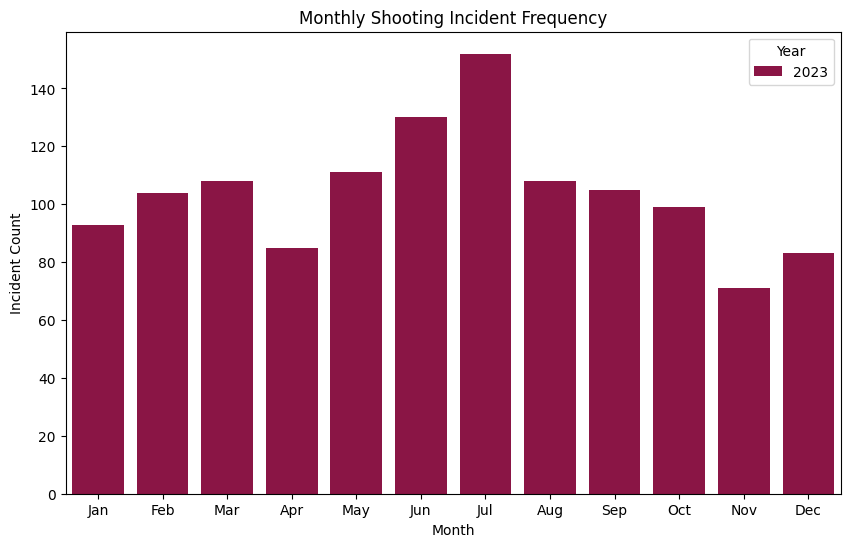

Plotting Daily Incidents: 100%|██████████| 100/100 [00:01<00:00, 72.71it/s]


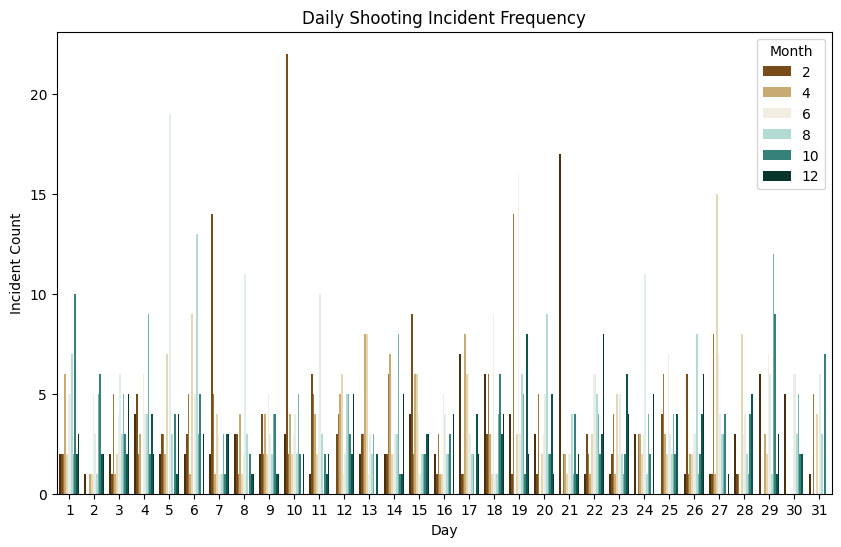

Plotting Hourly Incidents:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-69-d250c68a7908>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Hour', y='Incident_Count', data=hourly_incidents, palette=hourly_palette)
Plotting Hourly Incidents: 100%|██████████| 100/100 [00:00<00:00, 211.94it/s]


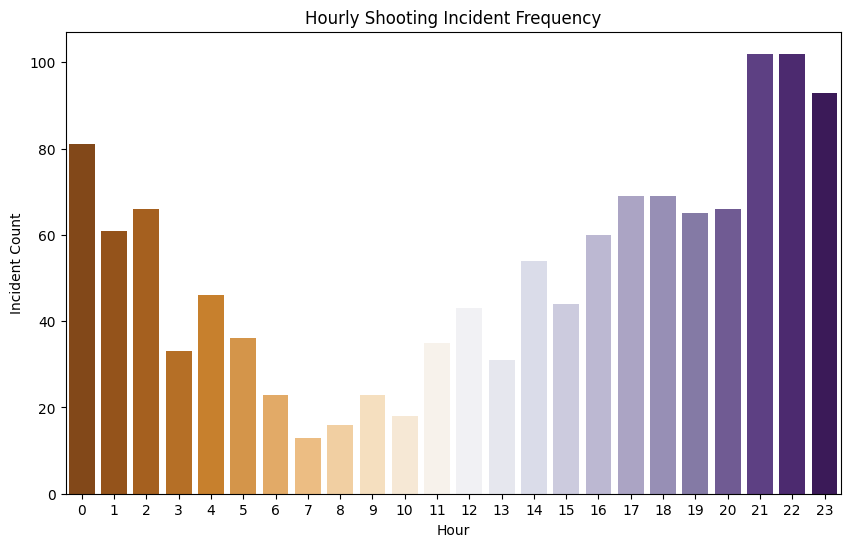

In [69]:
# Set color palettes for each plot
monthly_palette = 'Spectral'
daily_palette = 'BrBG'
hourly_palette = 'PuOr'

# Plot monthly_incidents
plt.figure(figsize=(10, 6))
with tqdm(total=100, desc='Plotting Monthly Incidents') as pbar:
    sns.barplot(x='Month', y='Incident_Count', hue='Year', data=monthly_incidents, palette=monthly_palette)
    pbar.update(100)
plt.title('Monthly Shooting Incident Frequency')
plt.xlabel('Month')
plt.ylabel('Incident Count')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

# Plot daily_incidents
plt.figure(figsize=(10, 6))
with tqdm(total=100, desc='Plotting Daily Incidents') as pbar:
    sns.barplot(x='Day', y='Incident_Count', hue='Month', data=daily_incidents, palette=daily_palette)
    pbar.update(100)
plt.title('Daily Shooting Incident Frequency')
plt.xlabel('Day')
plt.ylabel('Incident Count')
plt.legend(title='Month')
plt.show()

# Plot hourly_incidents
plt.figure(figsize=(10, 6))
with tqdm(total=100, desc='Plotting Hourly Incidents') as pbar:
    sns.barplot(x='Hour', y='Incident_Count', data=hourly_incidents, palette=hourly_palette)
    pbar.update(100)
plt.title('Hourly Shooting Incident Frequency')
plt.xlabel('Hour')
plt.ylabel('Incident Count')
plt.show()

# **Geospatial Analysis:**

For geospatial analysis of the NYPD Shooting Incident Data, you can plot the shooting incidents on a map using latitude and longitude coordinates.

In [72]:
import folium

# Create a map centered around New York City
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)

# Add shooting incident markers to the map
for index, row in df.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=row['LOCATION_DESC']).add_to(nyc_map)

# # Display the map
# nyc_map.save('shooting_incidents_map.html')

# Display the map
display(nyc_map)

# **Categorical Analysis:**

# **Demographic Analysis**:

Analyze demographic variables such as age group, sex, and race of both perpetrators and victims. You can investigate the distribution of these demographics and identify any patterns or disparities.

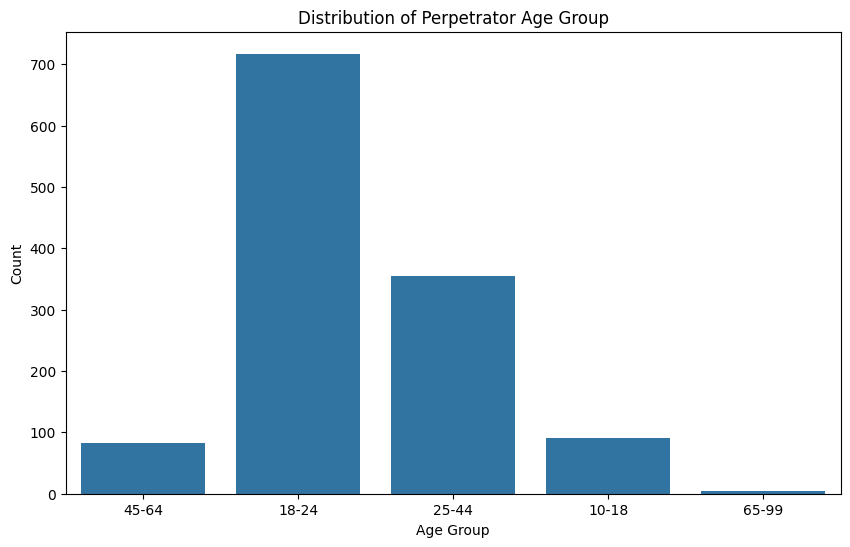

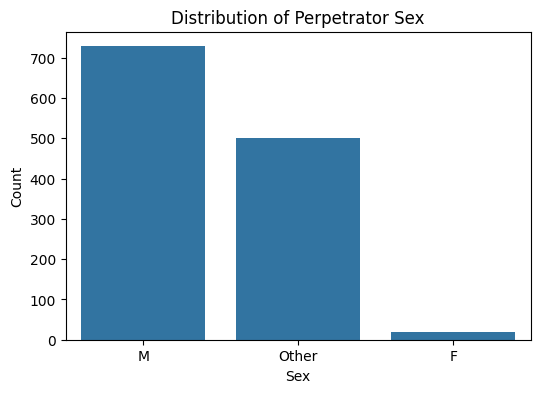

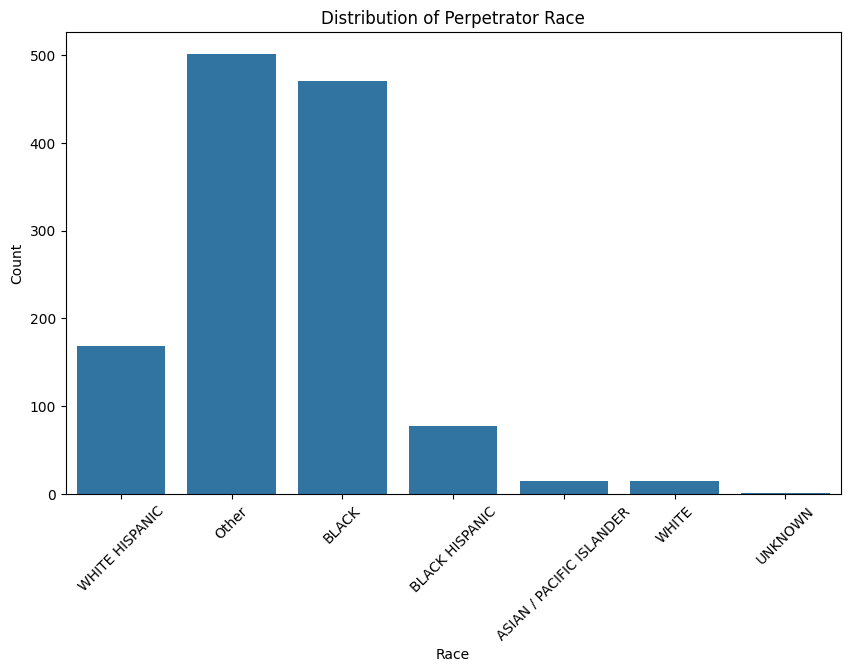

In [37]:
# Demographic analysis for perpetrators
plt.figure(figsize=(10, 6))
sns.countplot(x='PERP_AGE_GROUP', data=df)
plt.title('Distribution of Perpetrator Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='PERP_SEX', data=df)
plt.title('Distribution of Perpetrator Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='PERP_RACE', data=df)
plt.title('Distribution of Perpetrator Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

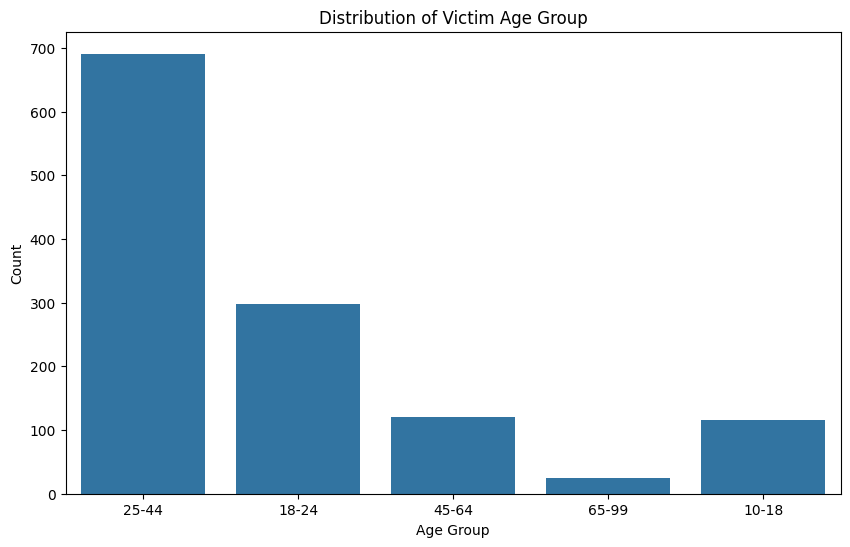

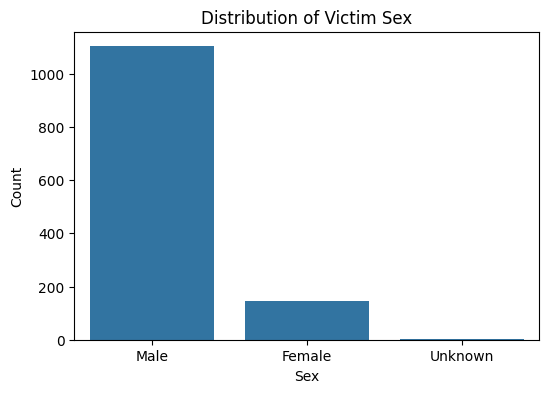

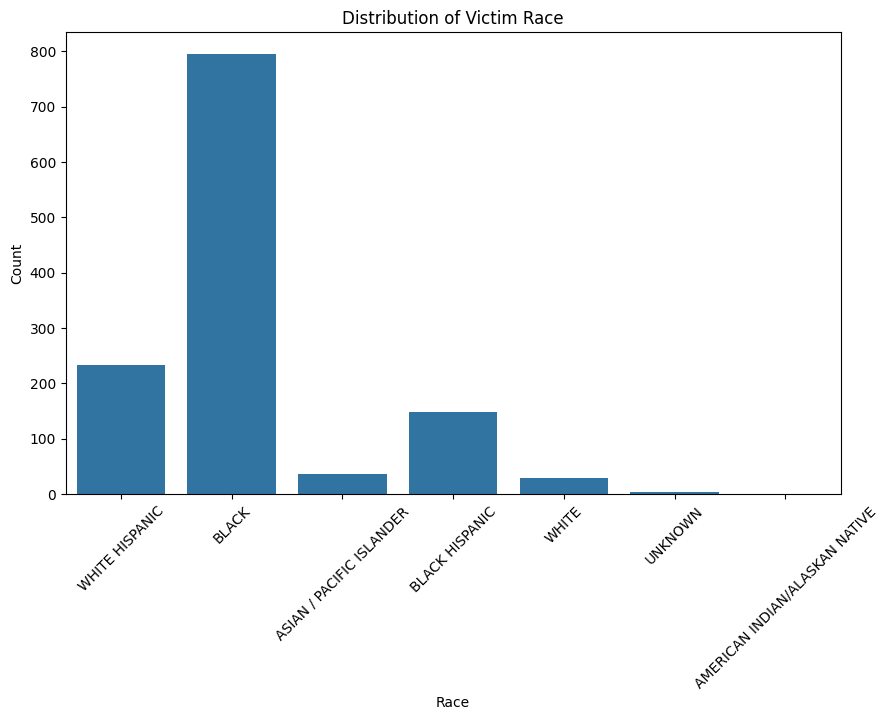

In [38]:
# Demographic analysis for victims
plt.figure(figsize=(10, 6))
sns.countplot(x='VIC_AGE_GROUP', data=df)
plt.title('Distribution of Victim Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x='VIC_SEX', data=df)
plt.title('Distribution of Victim Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='VIC_RACE', data=df)
plt.title('Distribution of Victim Race')
plt.xlabel('Race')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# **Location Analysis:**

Explore the shooting incident locations by borough, precinct, or jurisdiction code. Determine which areas have the highest number of shooting incidents and whether there are any spatial patterns.

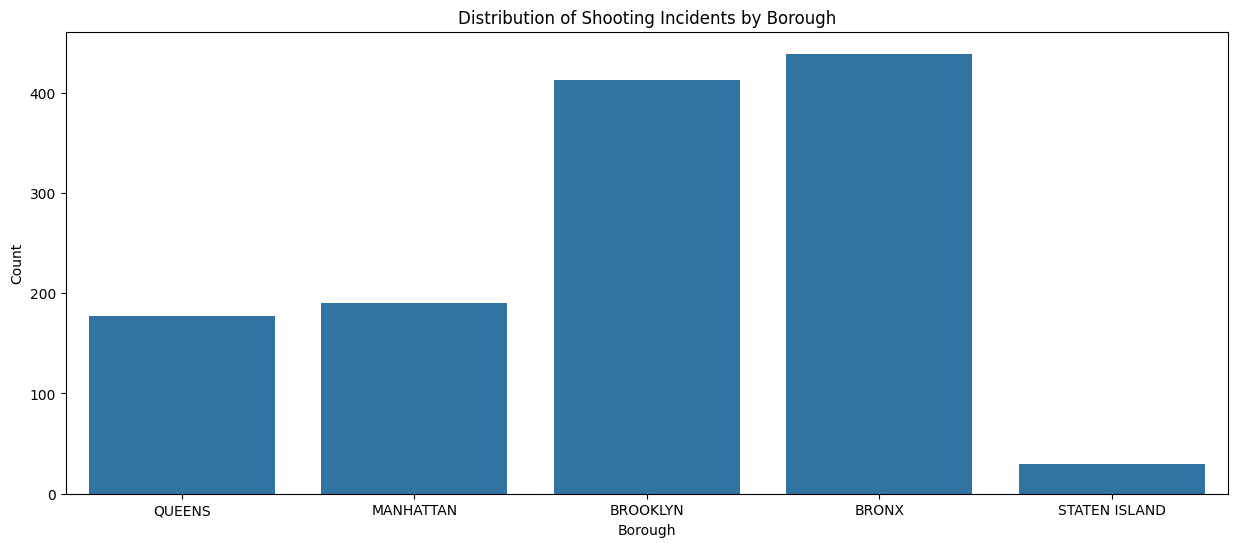

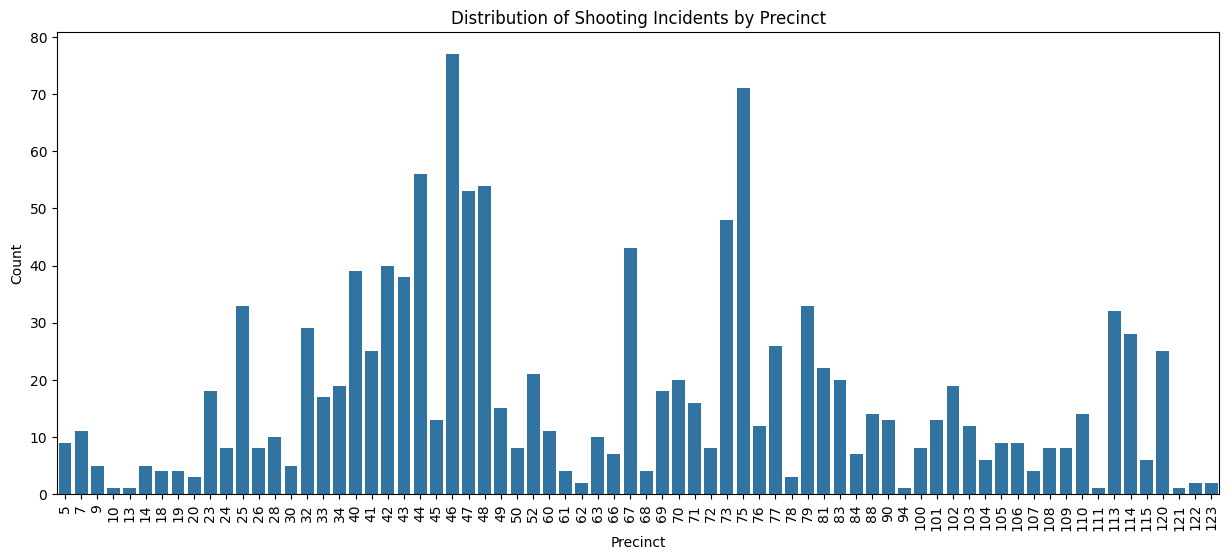

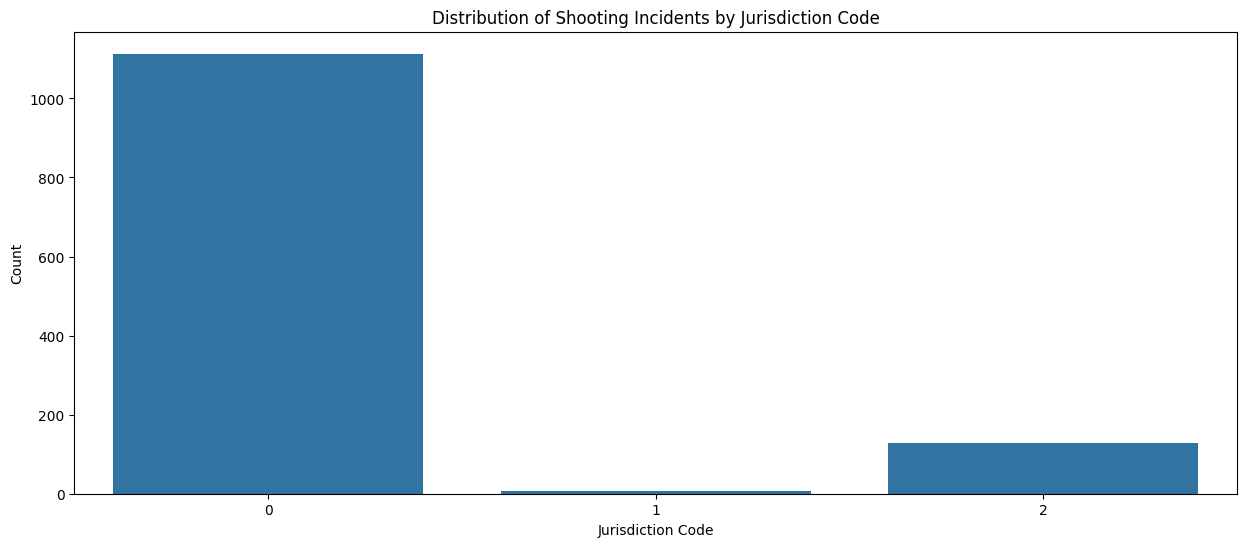

In [39]:
plt.figure(figsize=(15, 6))
sns.countplot(x='BORO', data=df)
plt.title('Distribution of Shooting Incidents by Borough')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(15, 6))
sns.countplot(x='PRECINCT', data=df)
plt.title('Distribution of Shooting Incidents by Precinct')
plt.xlabel('Precinct')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(15, 6))
sns.countplot(x='JURISDICTION_CODE', data=df)
plt.title('Distribution of Shooting Incidents by Jurisdiction Code')
plt.xlabel('Jurisdiction Code')
plt.ylabel('Count')
plt.show()

# **Statistical Analysis:**

Calculate summary statistics for categorical variables, such as the frequency of each category and the proportion of shooting incidents associated with each category.

In [40]:
# Summary statistics for categorical variables
perp_age_group_counts = df['PERP_AGE_GROUP'].value_counts()
perp_sex_counts = df['PERP_SEX'].value_counts()
perp_race_counts = df['PERP_RACE'].value_counts()

vic_age_group_counts = df['VIC_AGE_GROUP'].value_counts()
vic_sex_counts = df['VIC_SEX'].value_counts()
vic_race_counts = df['VIC_RACE'].value_counts()

# Create DataFrames for the counts
perp_age_group_df = pd.DataFrame({'Perpetrator Age Group Counts': perp_age_group_counts})
perp_sex_df = pd.DataFrame({'Perpetrator Sex Counts': perp_sex_counts})
perp_race_df = pd.DataFrame({'Perpetrator Race Counts': perp_race_counts})

vic_age_group_df = pd.DataFrame({'Victim Age Group Counts': vic_age_group_counts})
vic_sex_df = pd.DataFrame({'Victim Sex Counts': vic_sex_counts})
vic_race_df = pd.DataFrame({'Victim Race Counts': vic_race_counts})

# Display the DataFrames
# print("Perpetrator Age Group Counts:")
display(perp_age_group_df)

# print("\nPerpetrator Sex Counts:")
display(perp_sex_df)

# print("\nPerpetrator Race Counts:")
display(perp_race_df)

# print("\nVictim Age Group Counts:")
display(vic_age_group_df)

# print("\nVictim Sex Counts:")
display(vic_sex_df)

# print("\nVictim Race Counts:")
display(vic_race_df)

,Perpetrator Age Group Counts
PERP_AGE_GROUP,
18-24,717
25-44,354
10-18,91
45-64,82
65-99,5


,Perpetrator Sex Counts
PERP_SEX,
M,728
Other,501
F,20


,Perpetrator Race Counts
PERP_RACE,
Other,501
BLACK,470
WHITE HISPANIC,169
BLACK HISPANIC,78
ASIAN / PACIFIC ISLANDER,15
WHITE,15
UNKNOWN,1


,Victim Age Group Counts
VIC_AGE_GROUP,
25-44,691
18-24,298
45-64,121
10-18,115
65-99,24


,Victim Sex Counts
VIC_SEX,
Male,1103
Female,145
Unknown,1


,Victim Race Counts
VIC_RACE,
BLACK,795
WHITE HISPANIC,234
BLACK HISPANIC,149
ASIAN / PACIFIC ISLANDER,36
WHITE,30
UNKNOWN,4
AMERICAN INDIAN/ALASKAN NATIVE,1


# **Correlation Analysis:**

Explore relationships between categorical variables, such as the relationship between perpetrator demographics and victim demographics.

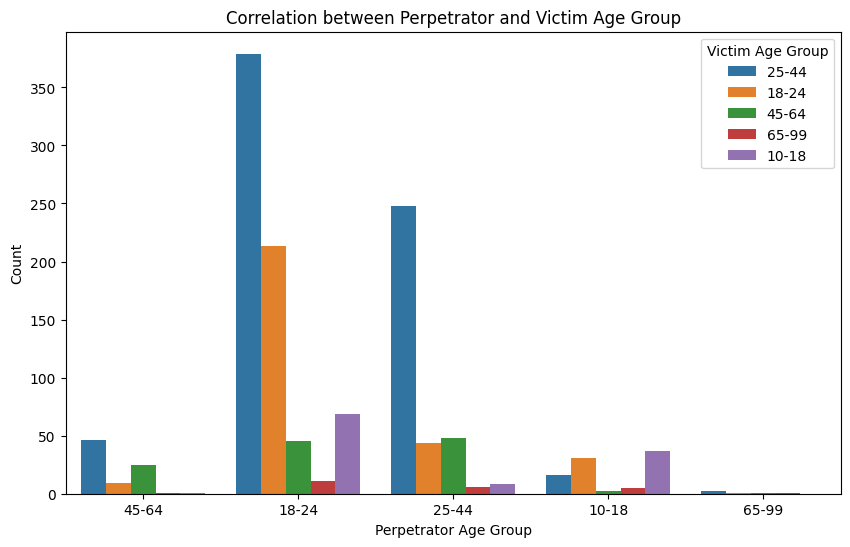

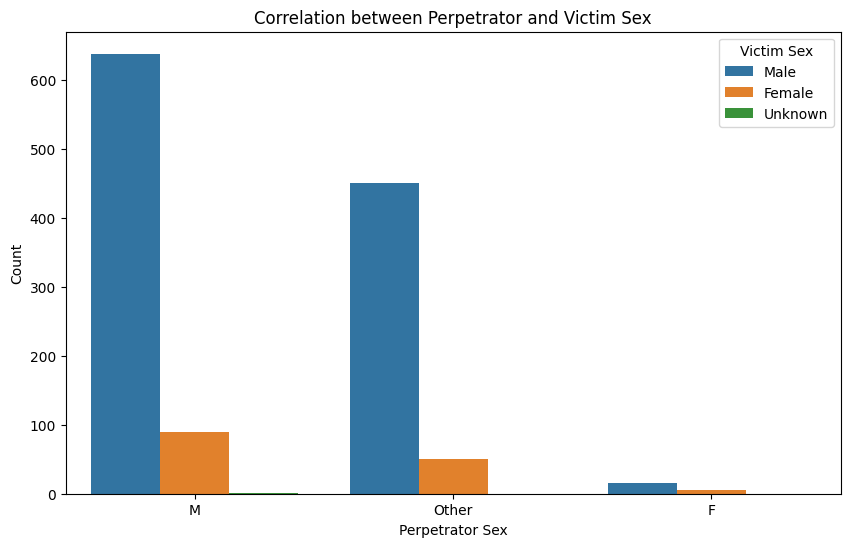

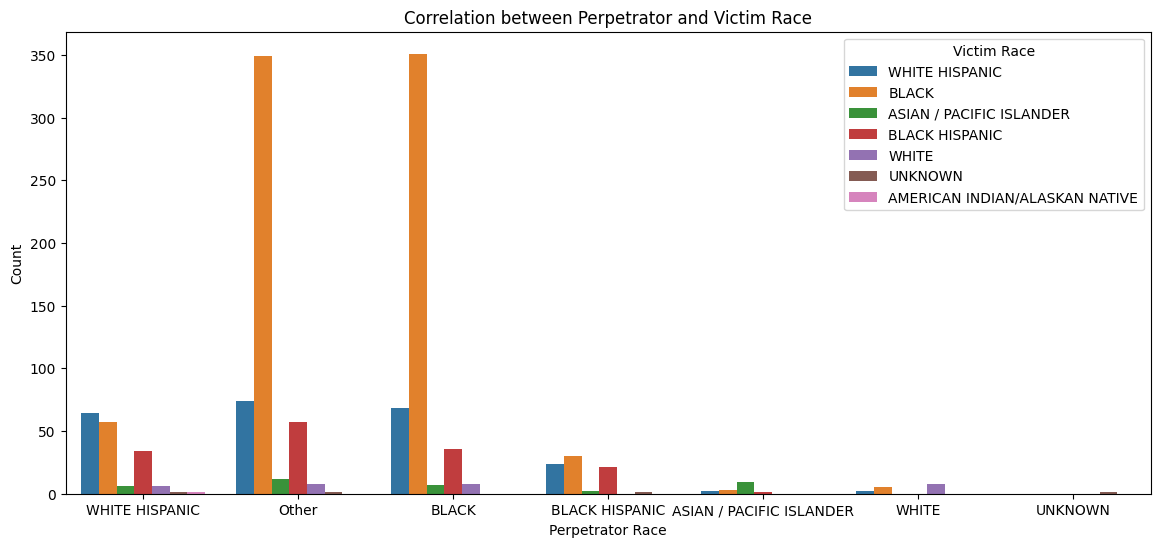

In [41]:
# Correlation analysis for perpetrator and victim demographics
plt.figure(figsize=(10, 6))
sns.countplot(x='PERP_AGE_GROUP', hue='VIC_AGE_GROUP', data=df)
plt.title('Correlation between Perpetrator and Victim Age Group')
plt.xlabel('Perpetrator Age Group')
plt.ylabel('Count')
plt.legend(title='Victim Age Group')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='PERP_SEX', hue='VIC_SEX', data=df)
plt.title('Correlation between Perpetrator and Victim Sex')
plt.xlabel('Perpetrator Sex')
plt.ylabel('Count')
plt.legend(title='Victim Sex')
plt.show()

plt.figure(figsize=(14, 6))
sns.countplot(x='PERP_RACE', hue='VIC_RACE', data=df)
plt.title('Correlation between Perpetrator and Victim Race')
plt.xlabel('Perpetrator Race')
plt.ylabel('Count')
plt.legend(title='Victim Race')
plt.show()

# =========================================================================================================================================================================================================================================================================================================================================================

**Problem statement for classification task:**

Classification Task Problem Statement: Classifying shooting incidents in New York City into "high-risk" and "low-risk" categories based on various features such as borough, location description, suspect and victim details. The objective of this classification task is to aid law enforcement agencies in identifying patterns and factors contributing to high-risk incidents, enabling them to prioritize response efforts and deploy preventive measures effectively in vulnerable areas.

In [44]:
df.columns

Index(['OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC', 'PRECINCT',
       'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'Latitude', 'Longitude',
       'New Georeferenced Column', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [45]:
X = df[['BORO', 'LOC_OF_OCCUR_DESC', 'PERP_AGE_GROUP','VIC_AGE_GROUP']]
y = df['STATISTICAL_MURDER_FLAG']

In [46]:
# Assuming X contains categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Apply one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Now X_encoded contains numeric features
print(X_encoded.head())  # Check the transformed features

   BORO_BROOKLYN  BORO_MANHATTAN  BORO_QUEENS  BORO_STATEN ISLAND  \
0          False           False         True               False   
1          False            True        False               False   
2           True           False        False               False   
3          False           False         True               False   
4          False            True        False               False   

   LOC_OF_OCCUR_DESC_OUTSIDE  PERP_AGE_GROUP_18-24  PERP_AGE_GROUP_25-44  \
0                       True                 False                 False   
1                       True                  True                 False   
2                       True                  True                 False   
3                       True                  True                 False   
4                       True                  True                 False   

   PERP_AGE_GROUP_45-64  PERP_AGE_GROUP_65-99  VIC_AGE_GROUP_18-24  \
0                  True                 False             

In [47]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target variable
y_encoded = label_encoder.fit_transform(y)

# Now y_encoded contains numeric labels
print(y_encoded[:15])  # Check the transformed labels


[0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]


In [48]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

Grid Search: Cross Validation

In [62]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Wrap GridSearchCV with tqdm
with tqdm(total=len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['min_samples_split'])) as pbar:
    grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=0), param_grid_rf, cv=5, scoring='roc_auc_ovr')

    grid_search_rf.fit(X_train, y_train)
    best_params_rf = grid_search_rf.best_params_
    best_model_rf = grid_search_rf.best_estimator_
    print("Best parameters for RandomForest:", best_params_rf)
    pbar.update()

param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

# Wrap GridSearchCV with tqdm
with tqdm(total=len(param_grid_xgb['n_estimators']) * len(param_grid_xgb['learning_rate']) * len(param_grid_xgb['max_depth'])) as pbar:
    grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=0), param_grid_xgb, cv=5, scoring='roc_auc_ovr')
    grid_search_xgb.fit(X_train, y_train)

    best_params_xgb = grid_search_xgb.best_params_
    best_model_xgb = grid_search_xgb.best_estimator_

    print("Best parameters for XGBoost:", best_params_xgb)
    pbar.update()

It takes some time to run, add the snapshot of results.

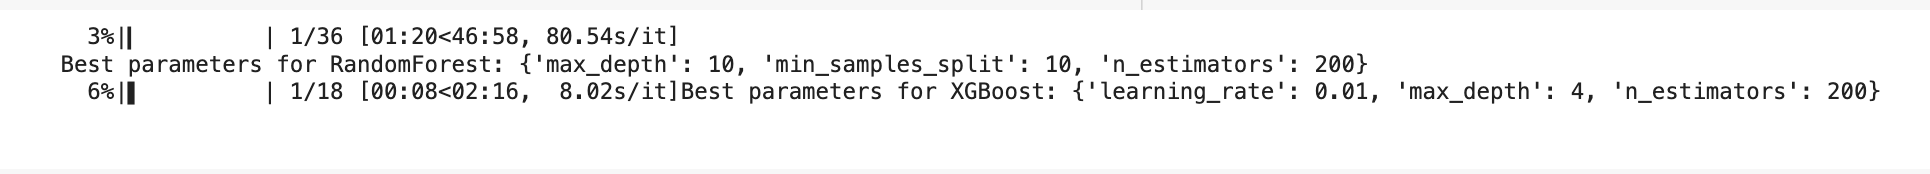

**Random Forest Classifier**

In [56]:
# RF
clf_rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, random_state=0)
clf_rf.fit(X_train, y_train)
y_pred_val_rf = clf_rf.predict(X_test)
accuracyrf = accuracy_score(y_test, y_pred_val_rf)
print(f"Accuracy rf: {accuracyrf:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_val_rf))

Accuracy rf: 0.8040

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       203
           1       0.40      0.09      0.14        47

    accuracy                           0.80       250
   macro avg       0.61      0.53      0.51       250
weighted avg       0.74      0.80      0.75       250



**Support Vector Machine**

In [57]:
# SVM
clf_svm = SVC(C=10, gamma=1, kernel='linear', probability=True, random_state=0)
clf_svm.fit(X_train, y_train)
y_pred_val_svm = clf_svm.predict(X_test)
accuracyrf = accuracy_score(y_test, y_pred_val_svm)
print(f"Accuracy svm: {accuracyrf:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_val_svm))

Accuracy svm: 0.8120

Classification Report:

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       203
           1       0.00      0.00      0.00        47

    accuracy                           0.81       250
   macro avg       0.41      0.50      0.45       250
weighted avg       0.66      0.81      0.73       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**XG Boost**

In [58]:
# XGBoost
clf_xgb = XGBClassifier(learning_rate=0.01, max_depth=4, n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=0)
clf_xgb.fit(X_train, y_train)
y_pred_val_xgb = clf_xgb.predict(X_test)
accuracyxgb = accuracy_score(y_test, y_pred_val_xgb)
print(f"\nAccuracy xgb: {accuracyxgb:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_val_xgb))


Accuracy xgb: 0.8240

Classification Report:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       203
           1       1.00      0.06      0.12        47

    accuracy                           0.82       250
   macro avg       0.91      0.53      0.51       250
weighted avg       0.86      0.82      0.76       250



**Decision Tree**

In [60]:
# Decision Tree
clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train,y_train)
y_pred_val_dt = clf_dt.predict(X_test)
accuracydt = accuracy_score(y_test, y_pred_val_dt)
print(f"\nAccuracy dt: {accuracydt:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_val_dt))


Accuracy dt: 0.7920

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.96      0.88       203
           1       0.31      0.09      0.13        47

    accuracy                           0.79       250
   macro avg       0.56      0.52      0.51       250
weighted avg       0.72      0.79      0.74       250



**Logistic Regression**

In [61]:
# Logistic Regression
logreg_classifier = LogisticRegression(C=100, penalty="l2", solver="saga", max_iter=3000)
logreg_classifier.fit(X_train, y_train)
y_pred_lc = logreg_classifier.predict(X_test)
accuracylr = accuracy_score(y_test, y_pred_lc)
print(f"\nAccuracy lr: {accuracylr:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_lc))


Accuracy lr: 0.8200

Classification Report:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       203
           1       1.00      0.04      0.08        47

    accuracy                           0.82       250
   macro avg       0.91      0.52      0.49       250
weighted avg       0.85      0.82      0.75       250



**Stochastic Gradient Descent**

In [64]:
# Stochastic Gradient Descent (SGD) classifier
sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train)
y_pred_sgd = sgd_classifier.predict(X_test)
accuracylr = accuracy_score(y_test, y_pred_sgd)
print(f"\nAccuracy lr: {accuracylr:.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_sgd))


Accuracy lr: 0.8120

Classification Report:

              precision    recall  f1-score   support

           0       0.81      1.00      0.90       203
           1       0.00      0.00      0.00        47

    accuracy                           0.81       250
   macro avg       0.41      0.50      0.45       250
weighted avg       0.66      0.81      0.73       250



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Model Complexity determination: Underfitting & Overfitting**

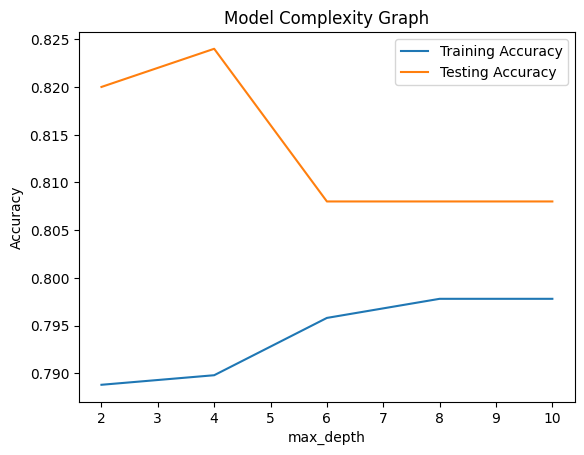

In [66]:
# Define a range of max_depth values to explore
max_depth_values = [2, 4, 6, 8, 10]

# Initialize lists to store training and testing accuracies
train_accuracies = []
test_accuracies = []

# Iterate over different max_depth values
for max_depth in max_depth_values:
    # Create XGBoost classifier with the current max_depth
    clf_xgb = XGBClassifier(learning_rate=0.01, max_depth=max_depth, n_estimators=200, use_label_encoder=False, eval_metric='mlogloss', random_state=0)

    # Fit the classifier to the training data
    clf_xgb.fit(X_train, y_train)

    # Predict labels for training and testing sets
    y_pred_train = clf_xgb.predict(X_train)
    y_pred_val = clf_xgb.predict(X_test)

    # Calculate training and testing accuracy
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_val)

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plot the model complexity graph
plt.plot(max_depth_values, train_accuracies, label='Training Accuracy')
plt.plot(max_depth_values, test_accuracies, label='Testing Accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Model Complexity Graph')
plt.legend()
plt.show()

**Project Conclusion Report**

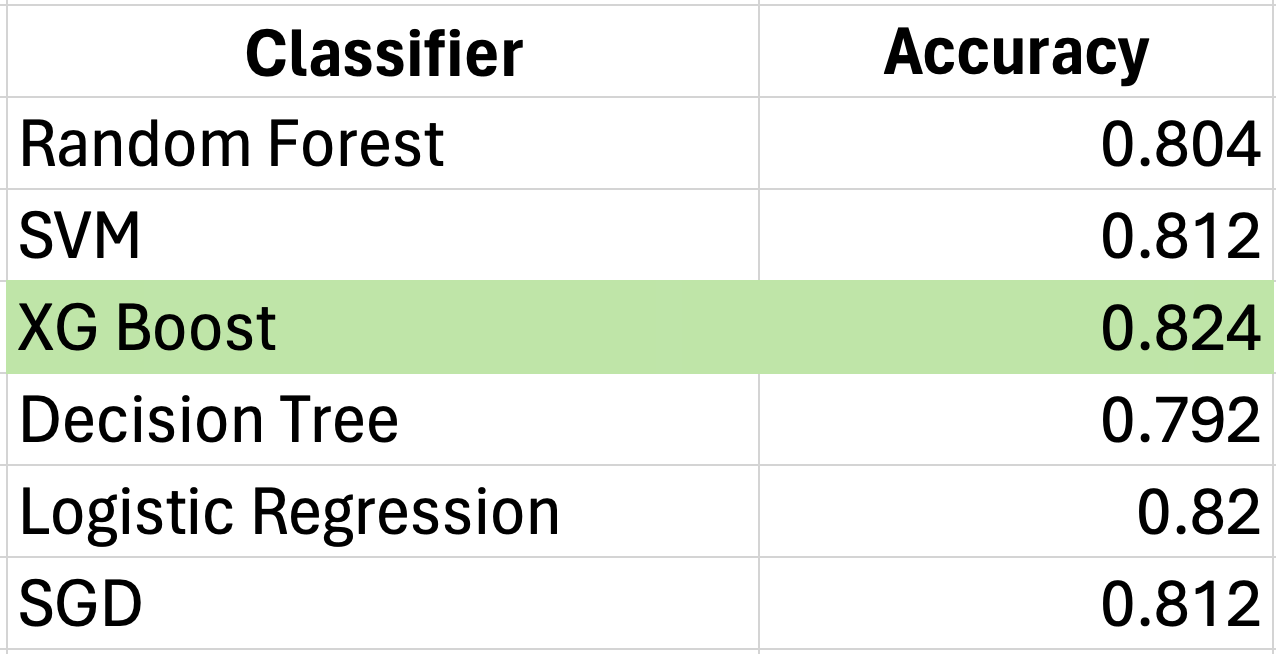

We can see above used classifiers predicted well on the given dataset, but XGBoost performed better than other models. As it's efficiency of combination of gradient boosting technique, regularization, optimized implementation, handling of missing values, and hyperparameter tuning makes XGBoost a powerful classifier capable of achieving high accuracy in various machine learning tasks.

The ensemble learning approach that combines the predictions of multiple base estimators (decision trees) to improves accuracy.

Regularization helps XGBoost to generalize better to unseen data and avoid memorizing the training set, which can lead to better performance on the test set and avoided overfitting.

By carefully performing cross validation and selecting & tuning hyperparameters, such as tree depth, learning rate, we were able to achieve higher accuracy compared to other classifiers.